# VRP Demo with SCIP
This file is intended to build the model for the CVRP using SCIP

In [1]:
from pyscipopt import Model, Pricer, SCIP_RESULT, SCIP_STAGE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np

from cffi import FFI
ffi = FFI()
labelling_lib = ffi.dlopen("Labelling/labelling_lib.so")

funDefs = "void initGraph(unsigned num_nodes, unsigned* node_data, double* edge_data, const double capacity); void labelling(double const * dual,const bool farkas, unsigned* result);"
ffi.cdef(funDefs, override=True)

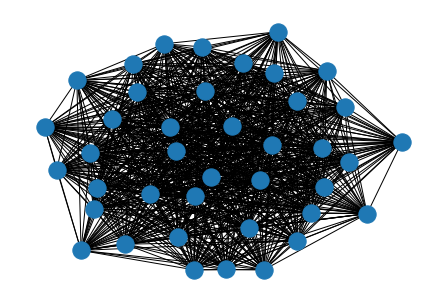

In [40]:
# Create Graph
G = nx.complete_graph(40)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = random.randint(1,10)
    
for node in G.nodes():
    G.nodes()[node]['demand'] = random.randint(1,10)

nx.draw(G)

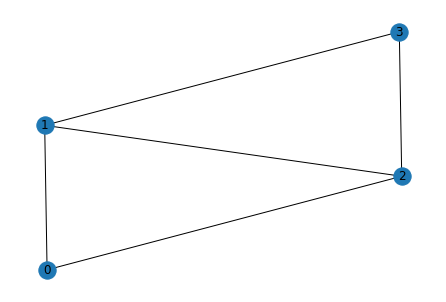

In [28]:
# Create Simple Graph for correctnes
G = nx.complete_graph(4)
G.remove_edge(0,3)
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1
G.edges[1,2]['weight'] = 1

for node in G.nodes():
    G.nodes()[node]['demand'] = 2

nx.draw(G,with_labels=True)

In [4]:
class VRP(Model):
    def __init__(self,graph):
        super().__init__()
        
        self.original_graph = graph
        self.graph = graph.copy()
        self.vars = {}
        self.cons = []

In [34]:
class VRPPricer(Pricer): 
    def pricerinit(self):
        self.data['cons'] = [self.model.getTransformedCons(con) for con in self.model.cons]
        self.data['vars'] = {path:self.model.getTransformedVar(var) for (path,var) in self.model.vars.items()}
        
        print(f" There are {len(self.model.getConss())} constraints in the model and {len(self.data['cons'])} of them are known to the pricer.")
        
        node_data = list(nx.get_node_attributes(self.model.graph,"demand").values())
        if not np.all(np.array(node_data)):
           print("PRICER_PY: The demands of all nodes must be > 0.")
        print(f"PRICER_PY: The demands are {node_data}")
        nodes_arr = ffi.cast("unsigned*", np.array(node_data).astype(np.uintc).ctypes.data)

        edges = nx.adjacency_matrix(self.model.graph,dtype=np.double).toarray()
        edges_arr = ffi.cast("double*", edges.ctypes.data)
        
        num_nodes = ffi.cast("unsigned",self.model.graph.number_of_nodes())
        
        capacity_ptr = ffi.cast("double",self.data['capacity'])
        labelling_lib.initGraph(num_nodes,nodes_arr,edges_arr, capacity_ptr)
    
    def pricerfarkas(self):
        dual = [self.model.getDualfarkasLinear(con) for con in self.data['cons']]
#         print(f"PRICER_PY: Farkas Values are {dual}")
        return self.labelling(dual, farkas=True)

    def pricerredcost(self):
        dual = [self.model.getDualsolLinear(con) for con in self.data['cons']]
#         print(f"PRICER_PY: Dual variables are {dual}")
        return self.labelling(dual)
    
    def labelling(self, dual,farkas=False):
        pointer_dual = ffi.cast("double*", np.array(dual,dtype=np.double).ctypes.data)
        
        # Should be capacity + 2, but I gave it a little more room
        # TODO: Possible improvement: result can be reused every time
        result = np.zeros(self.data['capacity'] + 10,dtype=np.uintc)
        result_arr = ffi.cast("unsigned*",result.ctypes.data)
        
        labelling_lib.labelling(pointer_dual, farkas,result_arr)
        
        if(result[0] == 1):
#             print("There are no paths with negative reduced costs")
            return {'result':SCIP_RESULT.SUCCESS}
        
        result_indices = np.insert(np.nonzero(result),0,0)
        path = tuple(result[result_indices])
        if path in self.data['vars'].keys():
            cost = self.model.getVarRedcost(self.data['vars'][path])
            print(f"PRICER_PY: Labelling found path {path} with negative reduced cost")
            print(f"PRICER_PY: Path already in variables with reduced cost {cost} with farkas {farkas}.")
            return {'result':SCIP_RESULT.SUCCESS}
        
        var = self.model.addVar(vtype="I",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
        weight = nx.path_weight(self.model.graph,path,"weight")
#         print(f"Added {path} with path weight {weight}")
        counts = np.unique(path[1:-1], return_counts=True)
        for i, node in enumerate(counts[0]):
            self.model.addConsCoeff(self.data['cons'][node-1], var ,counts[1][i])

        self.model.addConsCoeff(self.data['cons'][-1], var, 1)
        self.data['vars'][tuple(path)] = var
        
        return {'result':SCIP_RESULT.SUCCESS}

In [ ]:
model = VRP(G)
num_vehicles = 30

# Create pricer
pricer = VRPPricer()
pricer.data = {}
pricer.data["capacity"] = 40
pricer.data["num_vehicles"] = num_vehicles
model.includePricer(pricer, "pricer","does pricing")

# Create a valid set of variables and the constraints to it
for i in range(1,G.number_of_nodes()-1):
    #TODO: I should check, whether these paths are indeed feasible.
    path = (0,i,G.number_of_nodes()-1)
    cost = nx.path_weight(G,path,"weight")
    var = model.addVar(vtype="I",obj=cost)
    model.vars[path] = var
    cons = model.addCons(var == 1, name=str(node),modifiable=True)
    model.cons.append(cons)
    
# Add the convexity constraint, which limits the number of available vehicles
convexity_constraint = model.addCons(sum(model.vars.values()) <= num_vehicles, modifiable=True)
model.cons.append(convexity_constraint)

model.hideOutput()
model.optimize()
model.hideOutput(quiet=False)
model.printBestSol()
print(pricer.data['vars'])

 There are 39 constraints in the model and 39 of them are known to the pricer.
PRICER_PY: The demands are [1, 9, 7, 2, 6, 8, 8, 2, 9, 10, 6, 7, 4, 7, 7, 8, 6, 4, 7, 10, 2, 2, 8, 2, 8, 9, 8, 8, 6, 8, 6, 2, 6, 4, 1, 8, 4, 9, 2, 10]
PRICER_C: Graph data successfully copied to C.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.47240473061760646 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.4294221842169552 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.3084715091877115 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost

PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.439816605924925 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3000000000000007 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.18042655658754825 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 33, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7848754501354129 with farkas False.
PRICER_PY: Labelling found path (0, 31, 35, 31, 35, 31, 35, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.03788747233523715 with farkas False.
PRICER_PY: Labelling found path (0, 31, 35, 31, 35

PRICER_PY: Labelling found path (0, 23, 15, 23, 15, 23, 15, 23, 15, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4806962439471398 with farkas False.
PRICER_PY: Labelling found path (0, 23, 15, 23, 15, 23, 15, 23, 15, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.694425035465514 with farkas False.
PRICER_PY: Labelling found path (0, 23, 15, 23, 15, 27, 15, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.033302278983534 with farkas False.
PRICER_PY: Labelling found path (0, 31, 18, 30, 18, 31, 18, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.466272846211812 with farkas False.
PRICER_PY: Labelling found path (0, 31, 18, 31, 18, 31, 18, 31, 18, 31, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -14.430622215064297 with farkas False.
PRICER_PY: Labelling found path (0, 31

PRICER_PY: Labelling found path (0, 22, 24, 22, 2, 38, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -5.836016246331809 with farkas False.
PRICER_PY: Labelling found path (0, 22, 24, 22, 2, 38, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.157286075156012 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.2356123925195064 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 22, 24, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.250528454049455 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 22, 24, 22, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.9340164451321353 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 3

PRICER_PY: Labelling found path (0, 3, 35, 3, 35, 3, 35, 3, 21, 28, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.09027777777777501 with farkas False.
PRICER_PY: Labelling found path (0, 3, 35, 3, 35, 3, 35, 3, 21, 28, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.1879353195667406 with farkas False.
PRICER_PY: Labelling found path (0, 3, 35, 3, 35, 3, 35, 3, 21, 28, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.1879353195667548 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 36, 14, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.10707702619672332 with farkas False.
PRICER_PY: Labelling found path (0, 3, 35, 3, 35, 3, 35, 3, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -10.366739288307926 with farkas False.
PRICER_PY: Labelling found path (

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.290752952001224 with farkas False.
PRICER_PY: Labelling found path (0, 34, 38, 2, 22, 2, 22, 2, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.662352941176497 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 6, 13, 6, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0884130811288042 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 6, 13, 6, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9442299442299493 with farkas False.
PRICER_PY: Labelling found path (0, 23, 15, 27, 15, 27, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.358126410835215 with farkas False.
PRICER_PY: Labelling found path (0, 23, 15, 27, 15, 27, 30, 39) wit

PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 3, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.31871035940803 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 3, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9500330452782855 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 3, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1684210526315795 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 3, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5248287671233136 with farkas False.
PRICER_PY: Labelling found path (0, 19, 21, 19, 21, 19, 21, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.954659633257986 with farkas False.
PRICER_PY: Labelling found path (0, 32, 27, 15, 27, 3, 35, 39) wit

PRICER_PY: Labelling found path (0, 18, 11, 18, 11, 18, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.0426105717367875 with farkas False.
PRICER_PY: Labelling found path (0, 18, 11, 18, 11, 18, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.683774250440912 with farkas False.
PRICER_PY: Labelling found path (0, 18, 11, 18, 11, 18, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -9.27191987906274 with farkas False.
PRICER_PY: Labelling found path (0, 18, 11, 18, 11, 18, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -9.032846715328471 with farkas False.
PRICER_PY: Labelling found path (0, 18, 11, 18, 11, 18, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -9.199017199017199 with farkas False.
PRICER_PY: Labelling found path (0, 17, 5, 18, 11, 18, 17, 2

PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1368564842482893 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 32, 35, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.754488516815968 with farkas False.
PRICER_PY: Labelling found path (0, 7, 35, 7, 35, 7, 6, 38, 20, 17, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8477047498688712 with farkas False.
PRICER_PY: Labelling found path (0, 7, 35, 7, 35, 7, 6, 38, 20, 17, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.440168341547718 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 38, 6, 38, 6, 38, 6, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1523298643527333 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 3

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0877342016204832 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 38, 6, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6237327571879661 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 38, 6, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7294117647058815 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 17, 9, 12, 9, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8432105501445228 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 38, 6, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9262866902101532 with farkas False.
PRICER_PY: Labelling found path (0, 17, 

PRICER_PY: Labelling found path (0, 7, 16, 6, 38, 6, 38, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -5.7499999999999964 with farkas False.
PRICER_PY: Labelling found path (0, 7, 6, 38, 6, 38, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.455650929899857 with farkas False.
PRICER_PY: Labelling found path (0, 7, 6, 38, 6, 38, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.48674242424242564 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5466666666666669 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 6, 10, 1, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1146750524109024 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 

PRICER_PY: Labelling found path (0, 15, 23, 15, 23, 15, 23, 15, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7075213617480927 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 36, 14, 36, 17, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5474316249138127 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 14, 36, 14, 36, 2, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1498722971992468 with farkas False.
PRICER_PY: Labelling found path (0, 22, 2, 22, 2, 36, 17, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8564993564993557 with farkas False.
PRICER_PY: Labelling found path (0, 22, 2, 36, 2, 36, 17, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8562499999999993 with farkas False.
PRICER_PY: Labelling found path (0, 22, 2, 22, 2, 36

PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 12, 4, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8888552484180643 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 12, 4, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9975234460638998 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 19, 31, 2, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.5808383233532926 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 11, 36, 11, 36, 11, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.354411764705894 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 11, 36, 11, 36, 11, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.295154185022021 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 11, 36, 11, 36, 11, 39) with

PRICER_PY: Labelling found path (0, 17, 36, 14, 36, 14, 36, 9, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8784693019343983 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 14, 36, 9, 5, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8460019743336655 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 14, 36, 9, 5, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8152145301395155 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 14, 36, 14, 36, 9, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3767313019390528 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 14, 36, 14, 36, 9, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3917710196779964 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 28, 1, 28, 7, 13, 39) with 

PRICER_PY: Labelling found path (0, 3, 27, 5, 22, 5, 23, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5519880410895901 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 22, 5, 23, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5584708493222621 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 22, 5, 23, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6161508957558794 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.43902701013612244 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.054214717179123184 with farkas False.
PRICER_PY: Labelling found path (0, 23, 5, 22, 5, 27, 3, 38, 39) 

PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 36, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5910931174088994 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 36, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4562656941289127 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 36, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7849335535110455 with farkas False.
PRICER_PY: Labelling found path (0, 20, 38, 21, 14, 21, 14, 21, 14, 21, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5736751528099227 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4490365502710318 with farkas False.
PRICER_PY: Labelling fou

PRICER_PY: Labelling found path (0, 20, 26, 20, 26, 24, 26, 21, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.195530726256983 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 26, 24, 26, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -12.248533601474811 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 26, 24, 26, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -13.269551690001425 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 26, 24, 26, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -13.176533578093924 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 26, 24, 26, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.019256881866458 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 26, 24, 26

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8271483761990943 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9656646070059303 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9867710069789908 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9678601539427945 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7692789914440503 with farkas False.


PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.2215859816713674 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.011799831430888474 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.594201384821865 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5666038472854318 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.574227822461693

PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.5806993276244388 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.4499999999999993 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.4499999999999993 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 33, 11, 33, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5661357743433957 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7766114569047318 with farkas False.
PRICER_PY: Labelling found path (0,

PRICER_PY: Labelling found path (0, 34, 1, 4, 12, 4, 12, 4, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.692307692307693 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 4, 12, 4, 1, 34, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.3412954594362034 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 4, 12, 4, 1, 34, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.6167612396333446 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 4, 12, 4, 1, 34, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8965683905268094 with farkas False.
PRICER_PY: Labelling found path (0, 15, 12, 4, 12, 4, 31, 34, 20, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1486062690036114 with farkas False.
PRICER_PY: Labelling found path (0, 34

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5381875078427054 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5836490821584714 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5163759817073625 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8414811746177175 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.47354614331512046 with farkas False.
PRICER_PY: Labelling found path (0, 7,

PRICER_PY: Labelling found path (0, 23, 1, 23, 1, 23, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.5217981914512535 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 23, 1, 23, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.455210461202043 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 23, 1, 23, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.692123351291201 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 23, 1, 23, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.390349619004937 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 23, 1, 23, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.189368886818798 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 23, 1, 23, 

PRICER_PY: Labelling found path (0, 17, 10, 1, 10, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.563114035087725 with farkas False.
PRICER_PY: Labelling found path (0, 17, 10, 1, 10, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.317769790005691 with farkas False.
PRICER_PY: Labelling found path (0, 17, 10, 1, 10, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.190883738307782 with farkas False.
PRICER_PY: Labelling found path (0, 17, 10, 1, 10, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.171551647631471 with farkas False.
PRICER_PY: Labelling found path (0, 17, 10, 1, 10, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.692953135112461 with farkas False.
PRICER_PY: Labelling found path (0, 26, 36, 26, 36, 26, 36, 17, 39) wi

PRICER_PY: Labelling found path (0, 32, 31, 35, 31, 35, 31, 35, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.5830329226490463 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9702274256249979 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.062347363884502 with farkas False.
PRICER_PY: Labelling found path (0, 3, 38, 14, 21, 14, 1, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.22526737447983436 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 14, 1, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.24869443000341818 with farkas False.
PRICER_PY: Labelling found path (0, 3, 38, 14, 1, 14, 

PRICER_PY: Labelling found path (0, 31, 32, 31, 32, 31, 32, 31, 32, 31, 7, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -53.347027027027025 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 32, 31, 32, 31, 32, 31, 32, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -71.0 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 32, 31, 32, 31, 32, 31, 32, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -62.29800307219662 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 32, 31, 32, 31, 32, 31, 32, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -60.514285714285705 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 32, 31, 32, 31, 32, 31, 32, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -71.0 with farkas False.
PRICER_PY: Labelling 

PRICER_PY: Labelling found path (0, 7, 16, 6, 16, 7, 16, 6, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.445970963655853 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 1, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.5329695316052785 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 1, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.529904974846282 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 6, 38, 6, 38, 6, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7664670658682589 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 6, 38, 6, 38, 6, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8299908842297192 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 1, 12, 39

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9448669747563656 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9555016491524118 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9599815456324841 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8586937246152981 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9013539433599913 with farkas False.
PRICER_PY: Labelling found path (0,

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3878506362876095 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4472561215957533 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4134075263709427 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5415331871964248 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5730941688661453 with farkas False.
PRICER_PY: Labelling found path (0,

PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.2592592592592595 with farkas False.
PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8101589579487687 with farkas False.
PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7924948913245373 with farkas False.
PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7935032483758242 with farkas False.
PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9458761719280737 with farkas False.
PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37,

PRICER_PY: Labelling found path (0, 23, 5, 23, 1, 10, 1, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7576284472631656 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5335427586543027 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5335427586543027 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5510001813921548 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.486885712069899 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7,

PRICER_PY: Labelling found path (0, 3, 27, 3, 27, 6, 27, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8398466115810876 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 3, 27, 6, 27, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.345810402572681 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 3, 27, 6, 27, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.3289915966386587 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 3, 27, 6, 27, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.410190941385444 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 3, 27, 6, 27, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.9816532177124735 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 3, 27, 6, 27, 

PRICER_PY: Labelling found path (0, 23, 5, 9, 5, 9, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -5.244663117707159 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 30, 28, 30, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -10.000000000000004 with farkas False.
PRICER_PY: Labelling found path (0, 9, 28, 30, 28, 9, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -7.884244372990473 with farkas False.
PRICER_PY: Labelling found path (0, 30, 28, 30, 28, 30, 27, 3, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.8427536231884076 with farkas False.
PRICER_PY: Labelling found path (0, 30, 28, 30, 28, 30, 28, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.6352290679304673 with farkas False.
PRICER_PY: Labelling found path (0, 30, 28, 30, 28, 30, 28, 7, 39) with ne

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7805424485826435 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.778359175286738 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.6939494078315214 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7196380236949373 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7039599870450566 

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.2701616701536391 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5517879631861948 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5549998579800182 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.4727935532870493 with farkas False.
PRICER_PY: Labelling found path (0, 19, 13, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5186906321650451 with farkas False.
PRICER_PY: Labelling found path (0, 19, 1

PRICER_PY: Labelling found path (0, 7, 28, 30, 28, 30, 28, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.8011443734969568 with farkas False.
PRICER_PY: Labelling found path (0, 7, 28, 30, 28, 30, 28, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.7482858058314683 with farkas False.
PRICER_PY: Labelling found path (0, 7, 28, 30, 28, 30, 28, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.3775148750954997 with farkas False.
PRICER_PY: Labelling found path (0, 7, 28, 7, 28, 30, 28, 7, 35, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.4491741309885846 with farkas False.
PRICER_PY: Labelling found path (0, 7, 28, 30, 28, 30, 28, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.4568772796799756 with farkas False.
PRICER_PY: Labelling found path (0, 7, 28,

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4472392413039756 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2915039918617754 with farkas False.
PRICER_PY: Labelling found path (0, 34, 38, 6, 27, 6, 38, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.13476874540760697 with farkas False.
PRICER_PY: Labelling found path (0, 34, 38, 6, 27, 6, 38, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.13476874540759454 with farkas False.
PRICER_PY: Labelling found path (0, 34, 38, 6, 27, 6, 38, 6, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.14313780115021757 with farkas False.
PRICER_PY: Labelling found

PRICER_PY: Labelling found path (0, 26, 24, 26, 13, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.6639792734854915 with farkas False.
PRICER_PY: Labelling found path (0, 26, 24, 26, 13, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.6657581922230627 with farkas False.
PRICER_PY: Labelling found path (0, 26, 24, 26, 13, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.737513591512805 with farkas False.
PRICER_PY: Labelling found path (0, 26, 24, 26, 13, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.754105008162611 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 28, 30, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.3456887486855926 with farkas False.
PRICER_PY: Labelling found path (0, 26, 24, 26, 28, 27, 34, 39) with negati

PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1903317392151251 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6455581929152885 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.672556185178065 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6947598888212152 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7809308159708017 with farkas False.
PRICER_PY: Labelling found path (0, 7, 1

PRICER_PY: Labelling found path (0, 17, 20, 38, 20, 38, 21, 37, 2, 37, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.1681715337350198 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 38, 20, 38, 21, 37, 2, 37, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.007323699980247511 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7709460205320671 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6063977746870641 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7297459555106052 with farkas False.
PRICER_PY: Labelling found 

PRICER_PY: Labelling found path (0, 7, 16, 6, 13, 6, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.042087542087543284 with farkas False.
PRICER_PY: Labelling found path (0, 22, 24, 22, 24, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.336734693877538 with farkas False.
PRICER_PY: Labelling found path (0, 22, 24, 31, 11, 18, 11, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9548387096774178 with farkas False.
PRICER_PY: Labelling found path (0, 22, 24, 22, 24, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -5.0 with farkas False.
PRICER_PY: Labelling found path (0, 22, 24, 22, 24, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.307317073170733 with farkas False.
PRICER_PY: Labelling found path (0, 31, 24, 22, 24, 22, 39) with negative reduced cost
PRICER_PY: Pat

PRICER_PY: Labelling found path (0, 23, 5, 9, 5, 23, 1, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5497440865189986 with farkas False.
PRICER_PY: Labelling found path (0, 23, 5, 9, 5, 23, 1, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5491601894040805 with farkas False.
PRICER_PY: Labelling found path (0, 23, 5, 23, 1, 10, 1, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.13455732494048078 with farkas False.
PRICER_PY: Labelling found path (0, 23, 5, 23, 1, 10, 1, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.13320864876446237 with farkas False.
PRICER_PY: Labelling found path (0, 23, 5, 23, 1, 10, 1, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.15558277240979734 with farkas False.
PRICER_PY: Labelling found path (0, 23, 5, 23, 1, 10, 1, 34, 39) with

PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7574473407347782 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7617096179724463 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 27, 5, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3953524490225604 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 15, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0674604782550787 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 27, 5, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3923078452950755 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 27, 5, 23, 33, 39

PRICER_PY: Labelling found path (0, 7, 5, 7, 36, 14, 36, 14, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.1399152818507794 with farkas False.
PRICER_PY: Labelling found path (0, 7, 5, 7, 36, 14, 36, 14, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.14991364196566082 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 14, 36, 14, 36, 14, 36, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9667152575315825 with farkas False.
PRICER_PY: Labelling found path (0, 7, 5, 7, 36, 14, 36, 14, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.13456262284003628 with farkas False.
PRICER_PY: Labelling found path (0, 7, 5, 7, 36, 14, 36, 14, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.0924778123262584 with farkas False.
PRICER_PY: Labelling found path (0

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6431046057205823 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7200242655152493 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7123867517211586 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6328088797887848 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6012000028988158 with farkas False.
PRICER_PY: Labelling found path (0,

PRICER_PY: Labelling found path (0, 20, 13, 20, 13, 20, 34, 20, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.1113551861886 with farkas False.
PRICER_PY: Labelling found path (0, 20, 13, 20, 13, 20, 34, 20, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.2693282722158195 with farkas False.
PRICER_PY: Labelling found path (0, 20, 13, 20, 13, 20, 34, 20, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.4106171919752875 with farkas False.
PRICER_PY: Labelling found path (0, 20, 13, 20, 13, 20, 34, 20, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.1361296965913965 with farkas False.
PRICER_PY: Labelling found path (0, 20, 34, 20, 34, 20, 13, 14, 21, 14, 21, 14, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.186795671610181 with farkas Fa

PRICER_PY: Labelling found path (0, 20, 13, 20, 13, 20, 13, 20, 34, 20, 34, 20, 34, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.624912307805296 with farkas False.
PRICER_PY: Labelling found path (0, 20, 13, 20, 34, 20, 13, 20, 13, 20, 34, 20, 34, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.507201789048551 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 9, 20, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6237060041407823 with farkas False.
PRICER_PY: Labelling found path (0, 23, 4, 23, 4, 23, 4, 23, 4, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5823329138648496 with farkas False.
PRICER_PY: Labelling found path (0, 20, 13, 20, 13, 20, 13, 20, 13, 20, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.117697427314816 with farkas Fal

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.37699312586025613 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7530221512028525 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7479729729729634 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7017078766250044 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8961329965811409 with farkas False.
PRICER_PY: Labelling f

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.372135328119688 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2869891678975929 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2684469430780023 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9700374531835187 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9714285714285733 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16,

PRICER_PY: Labelling found path (0, 3, 16, 12, 16, 12, 16, 12, 16, 3, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.764352469959945 with farkas False.
PRICER_PY: Labelling found path (0, 3, 16, 12, 16, 12, 16, 12, 16, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -5.824367224367222 with farkas False.
PRICER_PY: Labelling found path (0, 3, 16, 15, 23, 13, 23, 13, 28, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.486227892142608 with farkas False.
PRICER_PY: Labelling found path (0, 3, 12, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.106377053745465 with farkas False.
PRICER_PY: Labelling found path (0, 3, 28, 36, 9, 36, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.801503759398514 with farkas False.
PRICER_PY: Labelling found path (0, 3, 16,

PRICER_PY: Labelling found path (0, 17, 36, 25, 36, 28, 36, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -6.188082305250738 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.870997137780062 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9290451041866277 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9208852673385355 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9265425416086792 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 27, 15, 23, 33

PRICER_PY: Labelling found path (0, 3, 29, 27, 29, 27, 36, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -16.442346145301023 with farkas False.
PRICER_PY: Labelling found path (0, 3, 29, 27, 29, 27, 36, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -16.241625435963975 with farkas False.
PRICER_PY: Labelling found path (0, 3, 29, 27, 29, 27, 36, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -16.41734972677594 with farkas False.
PRICER_PY: Labelling found path (0, 3, 29, 27, 29, 27, 36, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -16.7407854714618 with farkas False.
PRICER_PY: Labelling found path (0, 3, 29, 27, 29, 27, 36, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -16.755700609225386 with farkas False.
PRICER_PY: Labelling found path (0, 3, 29, 27, 29, 27, 36, 38, 

PRICER_PY: Path already in variables with reduced cost -1.4453699167075023 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3732608071308263 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2990467892797888 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2427626858729006 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.264951538012916 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 39) with negative reduced cost
P

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8043401328156783 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.9094299525100134 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8984952155352346 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.048863064927634 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 21, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.037307523815489 w

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 16, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -9.531895504252734 with farkas False.
PRICER_PY: Labelling found path (0, 31, 16, 14, 16, 31, 16, 38, 37, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -15.682918538302786 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 7, 16, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.970433373835561 with farkas False.
PRICER_PY: Labelling found path (0, 17, 16, 14, 16, 14, 16, 38, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -16.857067642451923 with farkas False.
PRICER_PY: Labelling found path (0, 17, 16, 7, 16, 7, 16, 31, 27, 3, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.0590685391909744 with farkas False.
PRICER_PY: Labelling found pat

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5800843534616007 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9758084708873547 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8698615487716204 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5132092464725293 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1877856671319584 with farkas False.
PRICER_PY: Labelling found path

PRICER_PY: Labelling found path (0, 23, 1, 10, 1, 10, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.083750000000002 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 10, 1, 10, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8331428571428603 with farkas False.
PRICER_PY: Labelling found path (0, 23, 1, 10, 1, 10, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9393738977072275 with farkas False.
PRICER_PY: Labelling found path (0, 21, 37, 29, 20, 29, 37, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.5056818181818166 with farkas False.
PRICER_PY: Labelling found path (0, 21, 37, 21, 37, 21, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8593314763231241 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 10, 25, 39) with negative re

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.116913419891663 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0479674892583741 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0722991302752263 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1119909019345364 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0897938030326237 with farkas False.
PRICER_PY: Labelling found path (0, 

PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 31, 34, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.631682957926067 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 31, 34, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7125071892164314 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 31, 34, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.952230987275172 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 31, 34, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.3320718670992164 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 31, 34, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.0752788119570624 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 31, 3

PRICER_PY: Labelling found path (0, 31, 29, 20, 29, 26, 29, 31, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.918174544559328 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 20, 29, 26, 29, 31, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9181745445593101 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 20, 29, 26, 29, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.012553762853962 with farkas False.
PRICER_PY: Labelling found path (0, 31, 29, 26, 29, 20, 29, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.053475588173686 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9873040122369119 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 

PRICER_PY: Labelling found path (0, 17, 4, 23, 4, 23, 4, 23, 4, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0750739130789952 with farkas False.
PRICER_PY: Labelling found path (0, 17, 4, 23, 4, 23, 4, 23, 4, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1580272195571588 with farkas False.
PRICER_PY: Labelling found path (0, 17, 4, 23, 4, 23, 4, 23, 4, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4118115122945802 with farkas False.
PRICER_PY: Labelling found path (0, 17, 4, 23, 4, 23, 4, 23, 4, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4566987107746279 with farkas False.
PRICER_PY: Labelling found path (0, 17, 4, 23, 4, 23, 4, 23, 4, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3049008968149813 with farkas False.
PRICER_PY: Labelling

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8471854122389946 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8510318166545385 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3004620081145788 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1826958821467564 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7211725367388624 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35,

PRICER_PY: Labelling found path (0, 32, 11, 33, 11, 33, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.3517544466745175 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 33, 11, 33, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8458377935898298 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 33, 11, 33, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.949287369973769 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 33, 11, 33, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.307854895792362 with farkas False.
PRICER_PY: Labelling found path (0, 3, 11, 32, 11, 32, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7595355635842136 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 32, 11, 37, 38

PRICER_PY: Labelling found path (0, 34, 38, 13, 7, 16, 15, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.12734266050348 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3898186889818636 with farkas False.
PRICER_PY: Labelling found path (0, 19, 13, 38, 13, 38, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.0 with farkas False.
PRICER_PY: Labelling found path (0, 19, 13, 38, 13, 38, 13, 38, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.07399122807017022 with farkas False.
PRICER_PY: Labelling found path (0, 34, 35, 4, 18, 4, 35, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.3139673198284125 with farkas False.
PRICER_PY: Labelling found path (0, 34, 38, 13, 7, 16, 15, 16,

PRICER_PY: Labelling found path (0, 20, 17, 20, 17, 1, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.18661762319467634 with farkas False.
PRICER_PY: Labelling found path (0, 20, 17, 20, 17, 1, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.0413169282101844 with farkas False.
PRICER_PY: Labelling found path (0, 20, 17, 20, 17, 1, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.00172744721688467 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 22, 5, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7170038337655313 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 22, 5, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.468373493975907 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 5, 22, 5, 23, 33, 39

PRICER_PY: Labelling found path (0, 20, 17, 20, 17, 20, 17, 20, 17, 20, 17, 20, 17, 20, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.3814655172413772 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 24, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8583569405099 with farkas False.
PRICER_PY: Labelling found path (0, 3, 35, 3, 35, 3, 35, 3, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7535155810552325 with farkas False.
PRICER_PY: Labelling found path (0, 25, 6, 16, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.125370572632235 with farkas False.
PRICER_PY: Labelling found path (0, 3, 27, 15, 5, 15, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.883432963279244 with farkas False.
PRICER_PY: Labelling found path (0, 25, 6, 1

PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1186637292168093 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1466174876409365 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1259171212748917 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.1464182557986984 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.162960574858632 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 33, 

PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.336845121445796 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3092336729608132 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3434458487576713 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3443445480091185 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3731705992332124 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 25, 39

PRICER_PY: Labelling found path (0, 19, 25, 37, 29, 20, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7329681134990693 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 10, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9171300636165949 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 10, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.789300002139358 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 37, 29, 20, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9292952556425522 with farkas False.
PRICER_PY: Labelling found path (0, 9, 36, 26, 15, 24, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.148078473528617 with farkas False.
PRICER_PY: Labelling found path (0, 19, 25, 37, 29, 20, 34, 39) with negative redu

PRICER_PY: Labelling found path (0, 3, 10, 18, 10, 18, 10, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.72774837623286 with farkas False.
PRICER_PY: Labelling found path (0, 3, 10, 18, 10, 18, 10, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.193108944008493 with farkas False.
PRICER_PY: Labelling found path (0, 3, 10, 18, 10, 18, 10, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.214222381746197 with farkas False.
PRICER_PY: Labelling found path (0, 3, 10, 18, 10, 18, 10, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.227874015263211 with farkas False.
PRICER_PY: Labelling found path (0, 3, 10, 18, 10, 18, 10, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -8.710455124124799 with farkas False.
PRICER_PY: Labelling found path (0, 3, 10, 18, 10, 

PRICER_PY: Labelling found path (0, 37, 29, 37, 29, 3, 34, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -4.465088988851953 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 36, 14, 36, 11, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.08636363636363775 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 37, 12, 37, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0156250000000018 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 15, 23, 4, 23, 15, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.35603996366939583 with farkas False.
PRICER_PY: Labelling found path (0, 32, 11, 37, 12, 37, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -3.480512546716497 with farkas False.
PRICER_PY: Labelling found path (0, 37, 12, 37, 12, 37, 12, 39) with 

PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4665045086784616 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 15, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7255822036843647 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 15, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.553387045535704 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8166337934762762 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 23, 1, 10, 1, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.6156659663607442 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 3

PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7073051349530282 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7361242827216454 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7592043598565397 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7087204195171353 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6918675192656405 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 1, 23, 13, 38, 39)

PRICER_PY: Labelling found path (0, 17, 20, 29, 37, 12, 37, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.7600661886376106 with farkas False.
PRICER_PY: Labelling found path (0, 17, 10, 1, 10, 1, 23, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9198345259391782 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3460885203316977 with farkas False.
PRICER_PY: Labelling found path (0, 32, 35, 31, 35, 31, 35, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.490696825975876 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 29, 37, 21, 37, 21, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1508937960042047 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 29, 37, 21

PRICER_PY: Labelling found path (0, 32, 31, 24, 31, 24, 31, 24, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8589892294946218 with farkas False.
PRICER_PY: Labelling found path (0, 32, 31, 24, 31, 24, 31, 24, 31, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.774143703322167 with farkas False.
PRICER_PY: Labelling found path (0, 17, 12, 37, 12, 37, 12, 33, 23, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.192260106077761 with farkas False.
PRICER_PY: Labelling found path (0, 17, 12, 37, 12, 37, 12, 33, 23, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5371897888075097 with farkas False.
PRICER_PY: Labelling found path (0, 17, 12, 37, 12, 37, 21, 33, 23, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7593128551136346 with farkas False.
PRICER_PY: Labelling found path (0, 1

PRICER_PY: Labelling found path (0, 34, 1, 10, 16, 6, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8546655656482223 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 16, 6, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8879314114680312 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 16, 6, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8075021883528137 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 16, 6, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8809985413319534 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 16, 6, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.891017527782676 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 10, 16, 6, 16, 12, 39) 

PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.3305084745762734 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.2991071428571459 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.716560509554137 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.6666666666666607 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7196261682243055 with farkas False.
PRICER_PY: Labelling found path (0, 

PRICER_PY: Labelling found path (0, 34, 1, 10, 28, 10, 28, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0338157894736852 with farkas False.
PRICER_PY: Labelling found path (0, 31, 35, 31, 35, 31, 35, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0 with farkas False.
PRICER_PY: Labelling found path (0, 31, 35, 31, 35, 31, 35, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0 with farkas False.
PRICER_PY: Labelling found path (0, 31, 35, 31, 35, 31, 35, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0 with farkas False.
PRICER_PY: Labelling found path (0, 31, 35, 31, 35, 31, 35, 31, 35, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.0 with farkas False.
PRICER_PY: Labelling found path (0, 34, 1, 28, 13, 6, 13, 38, 39) with negative reduced cost
PRICER_

PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 21, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2918307344988875 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 21, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3554173115664305 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 21, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4138546426281628 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 21, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3965773489071864 with farkas False.
PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 21, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.3742174194205532 with farkas Fa

PRICER_PY: Labelling found path (0, 21, 7, 16, 7, 16, 7, 16, 7, 21, 38, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.9812132768361757 with farkas False.
PRICER_PY: Labelling found path (0, 21, 7, 16, 7, 16, 7, 16, 7, 21, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1405166116726768 with farkas False.
PRICER_PY: Labelling found path (0, 21, 7, 16, 7, 16, 7, 16, 7, 21, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1073347739523314 with farkas False.
PRICER_PY: Labelling found path (0, 21, 7, 16, 7, 16, 7, 16, 7, 21, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.1073347739523314 with farkas False.
PRICER_PY: Labelling found path (0, 21, 7, 16, 7, 16, 7, 16, 7, 21, 7, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.068507063612415

PRICER_PY: Labelling found path (0, 34, 31, 27, 21, 33, 21, 33, 21, 33, 21, 33, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.6457412495520316 with farkas False.
PRICER_PY: Labelling found path (0, 34, 31, 27, 21, 33, 21, 33, 21, 33, 21, 33, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.6663978722802106 with farkas False.
PRICER_PY: Labelling found path (0, 34, 31, 24, 31, 24, 31, 27, 33, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.6561903844300723 with farkas False.
PRICER_PY: Labelling found path (0, 21, 33, 21, 33, 21, 33, 21, 33, 21, 33, 21, 33, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.192759629449043 with farkas False.
PRICER_PY: Labelling found path (0, 34, 31, 24, 31, 27, 21, 33, 21, 33, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with redu

PRICER_PY: Labelling found path (0, 7, 33, 23, 38, 3, 27, 3, 27, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8311620635747516 with farkas False.
PRICER_PY: Labelling found path (0, 7, 33, 7, 33, 7, 33, 7, 33, 7, 33, 7, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.12025763275727286 with farkas False.
PRICER_PY: Labelling found path (0, 7, 5, 22, 5, 7, 33, 23, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.32659574468086205 with farkas False.
PRICER_PY: Labelling found path (0, 7, 5, 22, 5, 27, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7828179696616218 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 30, 18, 30, 18, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.8755270996943807 with farkas False.
PRICER_PY: Labelling found path (0, 7, 

PRICER_PY: Labelling found path (0, 7, 5, 27, 30, 27, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7301595794356182 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 30, 27, 30, 27, 3, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.4573689092595679 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 30, 18, 30, 36, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.8221817901364368 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 30, 18, 30, 36, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.9262540856462245 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 30, 18, 30, 36, 14, 21, 38, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.0893145105082276 with farkas False.
PRICER_PY: Labelling found path (0,

PRICER_PY: Labelling found path (0, 7, 36, 26, 36, 30, 36, 30, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.116360116166497 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 26, 36, 30, 36, 30, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.180061482374029 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 26, 36, 30, 36, 30, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5557554255938513 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 26, 36, 30, 36, 30, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5557392100805245 with farkas False.
PRICER_PY: Labelling found path (0, 7, 36, 26, 36, 30, 36, 30, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.493419085896491 with farkas False.
PRICER_PY: Labelling found p

PRICER_PY: Labelling found path (0, 7, 36, 30, 36, 30, 36, 30, 36, 7, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.1565424101223627 with farkas False.
PRICER_PY: Labelling found path (0, 17, 36, 26, 36, 26, 36, 30, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.2282853359342525 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.8656208743619693 with farkas False.
PRICER_PY: Labelling found path (0, 7, 16, 7, 16, 7, 16, 7, 16, 12, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.7879550199401884 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 17, 36, 14, 21, 14, 21, 33, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -0.1410843062381808 with farkas False.
PRICER_PY: Labelling found path (

PRICER_PY: Labelling found path (0, 21, 14, 21, 14, 21, 14, 21, 14, 21, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.188888888888883 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 17, 20, 17, 20, 17, 20, 17, 20, 17, 20, 17, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.5714285714285694 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 17, 20, 17, 20, 17, 20, 17, 20, 17, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -1.7968749999999964 with farkas False.
PRICER_PY: Labelling found path (0, 17, 20, 17, 20, 17, 20, 17, 20, 17, 20, 17, 39) with negative reduced cost
PRICER_PY: Path already in variables with reduced cost -2.238095238095241 with farkas False.


## Old Labelling

In [ ]:

    def simple_labeling(self,dual,farkas=False):
        for path in nx.all_simple_paths(self.model.graph,0,list(G.nodes())[-1]):
            if tuple(path) not in self.data['vars'].keys():
                if farkas:
                    weight = 0
                else:
                    weight = nx.path_weight(self.model.graph,path,"weight")
                load = 0
                
                for node in path[1:-1]:
                    weight -= dual[node-1]
                    load += self.model.graph.nodes()[node]['demand']
                if weight < 0 and load <= self.data['capacity']:
                    var = self.model.addVar(vtype="B",obj=nx.path_weight(self.model.graph,path,"weight"),pricedVar=True)
                    for node in path[1:-1]:
                        self.model.addConsCoeff(self.data['cons'][node-1], var ,1)
                    
                    self.model.addConsCoeff(self.data['cons'][-1], var, 1)
                    self.data['vars'][tuple(path)] = var
#                     print(f"Found path {path} with negative reduced cost")
                    return {'result':SCIP_RESULT.SUCCESS}
        return {'result':SCIP_RESULT.SUCCESS}